# Setup


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.7/364.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [13]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple
from collections import namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
if len(GPUs) > 0:
    gpu = GPUs[0]
    def printm():
        process = psutil.Process(os.getpid())
        print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
    printm()
else:
    print("No GPU found")

Gen RAM Free: 120.3 GB  | Proc size: 467.7 MB
GPU RAM Free: 15387MB | Used: 783MB | Util   5% | Total 16376MB


In [3]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .25, "num_cpus": 2}
else:
    client_resources = {"num_cpus": 2}

In [4]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics



def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Custom Strategy

In [6]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [14]:
from typing import Callable, Union
import json

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    # def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
    #     sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
    #     clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
    #     epochs_sc = 5
    #     epochs_hl = 3

    #     standard_config = {"lr": 0.001, "epochs": epochs_sc}
    #     higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
    #     fit_configurations = []

    #     for client in clients:
    #         # Choose config based on the previous training time
    #         last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded
    #         print(f"This is the last time {last_time}")
    #         config_to_use = standard_config if last_time < 13.8 else higher_lr_config
    #         fit_configurations.append((client, FitIns(parameters, config_to_use)))

    #     return fit_configurations

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [15]:
strategy = FedCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=3),
    strategy=strategy,  # <-- pass the new strategy here
    client_resources=client_resources,
)


INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout
2024-07-25 11:38:46,667	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 33844026163.0, 'accelerator_type:RTX': 1.0, 'memory': 68969394381.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37944) Training time for Client 7: 40.54 seconds [repeated 4x across cluster]
(ClientAppActor pid=37944) [Client 9] evaluate, config: {}
(ClientAppActor pid=37944) Epoch 9: train loss 0.037751, accuracy 0.573111 [repeated 3x across cluster]
(ClientAppActor pid=23204) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 41.276697874069214and 9habhhahah
this is tehb mode time [41.28]
This is ths last time not a fantasy 40.565757751464844and 2habhhahah
this is tehb mode time [41.28, 40.57]
This is ths last time not a fantasy 40.81755304336548and 0habhhahah
this is tehb mode time [41.28, 40.57, 40.82]
This is ths last time not a fantasy 40.91754102706909and 5habhhahah
this is tehb mode time [41.28, 40.57, 40.82, 40.92]
This is ths last time not a fantasy 40.9941291809082and 3habhhahah
this is tehb mode time [41.28, 40.57, 40.82, 40.92, 40.99]
This is ths last time not a fantasy 40.89833188056946and 8habhhahah
this is tehb mode time [41.28, 40.57, 40.82, 40.92, 40.99, 40.9]
This is ths last time not a fantasy 41.09951066970825and 6habhhahah
this is tehb mode time [41.28, 40.57, 40.82, 40.92, 40.99, 40.9, 41.1]
This is ths last time not a fantasy 40.541022539138794and 7habhhahah
this is tehb mode time [41.28, 40.57, 40.82, 40.92, 40.99, 40.9, 41.1, 40.54]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34796) [Client 9] evaluate, config: {}
(ClientAppActor pid=34796) Training time for Client 1: 35.67 seconds [repeated 3x across cluster]
(ClientAppActor pid=34796) Epoch 8: train loss 0.026952, accuracy 0.693333
(ClientAppActor pid=23204) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 35.67195439338684and 1habhhahah
this is tehb mode time [35.67]
This is ths last time not a fantasy 35.19016695022583and 9habhhahah
this is tehb mode time [35.67, 35.19]
This is ths last time not a fantasy 35.94545888900757and 0habhhahah
this is tehb mode time [35.67, 35.19, 35.95]
This is ths last time not a fantasy 35.69741201400757and 2habhhahah
this is tehb mode time [35.67, 35.19, 35.95, 35.7]
This is ths last time not a fantasy 36.024354219436646and 4habhhahah
this is tehb mode time [35.67, 35.19, 35.95, 35.7, 36.02]
This is ths last time not a fantasy 36.34775257110596and 3habhhahah
this is tehb mode time [35.67, 35.19, 35.95, 35.7, 36.02, 36.35]
This is ths last time not a fantasy 36.122742891311646and 7habhhahah
this is tehb mode time [35.67, 35.19, 35.95, 35.7, 36.02, 36.35, 36.12]
This is ths last time not a fantasy 36.348743200302124and 6habhhahah
this is tehb mode time [35.67, 35.19, 35.95, 35.7, 36.02, 36.35, 36.12, 36.35]
This is ths la

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37944) Epoch 9: train loss 0.012402, accuracy 0.873333 [repeated 5x across cluster]
(ClientAppActor pid=37944) [Client 7] evaluate, config: {}
(ClientAppActor pid=37944) Training time for Client 8: 40.05 seconds [repeated 3x across cluster]
(ClientAppActor pid=23204) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 204.16s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05975868802070618
INFO :      		round 2: 0.041840066015720365
INFO :      		round 3: 0.04650128004550934
INFO :      


History (loss, distributed):
	round 1: 0.05975868802070618
	round 2: 0.041840066015720365
	round 3: 0.04650128004550934

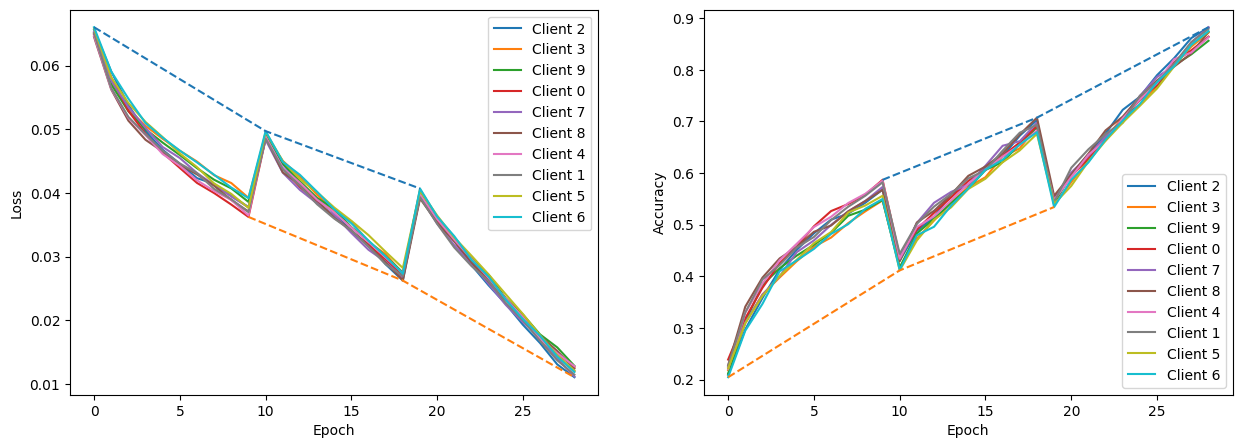

In [16]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

plot_metrics(strategy.client_metrics)

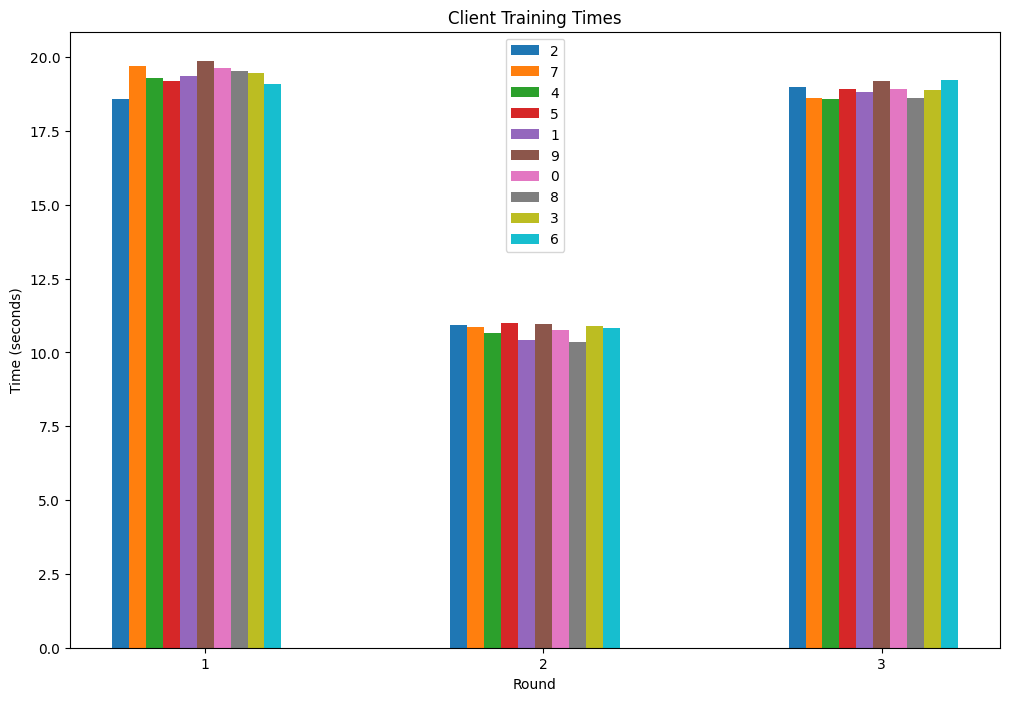

In [10]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

# FedAvg Strategy


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=5)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [ ]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-07-19 02:07:30,820	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'memory': 8018922702.0, 'object_store_memory': 4009461350.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 2}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 1 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=14801) 2024-07-19 02:07:35.978419: E external/local_xla/xla/stream

(ClientAppActor pid=14801) [Client 8] get_parameters
(ClientAppActor pid=14801) [Client 3] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.065185, accuracy 0.224000
(ClientAppActor pid=14801) Epoch 1: train loss 0.057703, accuracy 0.327111
(ClientAppActor pid=14801) Epoch 2: train loss 0.053120, accuracy 0.371111
(ClientAppActor pid=14801) Epoch 3: train loss 0.050480, accuracy 0.409111
(ClientAppActor pid=14801) Epoch 4: train loss 0.048216, accuracy 0.437556
(ClientAppActor pid=14801) [Client 4] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.064774, accuracy 0.221778
(ClientAppActor pid=14801) Epoch 1: train loss 0.055692, accuracy 0.347333
(ClientAppActor pid=14801) Epoch 2: train loss 0.051688, accuracy 0.403333
(ClientAppActor pid=14801) Epoch 3: train loss 0.048921, accuracy 0.422889
(ClientAppActor pid=14801) Epoch 4: train loss 0.047216, accuracy 0.452889
(ClientAppActor pid=14801) [Client 5] fit, config: {}
(ClientAppActor pid=14801) Epoch 0:

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.048291, accuracy 0.432667
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.05832881474494934
(ClientAppActor pid=14801) Client 0 accuracy 0.382
(ClientAppActor pid=14801) [Client 2] evaluate, config: {}
(ClientAppActor pid=14801) Client 2 loss 0.05865556526184082
(ClientAppActor pid=14801) Client 2 accuracy 0.358
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppActor pid=14801) Client 9 loss 0.05910161209106445
(ClientAppActor pid=14801) Client 9 accuracy 0.362
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.056831492900848386
(ClientAppActor pid=14801) Client 5 accuracy 0.378
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.056862039089202884
(ClientAppActor pid=14801) Client 7 accuracy 0.386
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAp

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) [Client 8] evaluate, config: {}
(ClientAppActor pid=14801) Client 8 loss 0.058699523448944094
(ClientAppActor pid=14801) Client 8 accuracy 0.346
(ClientAppActor pid=14801) [Client 3] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.050855, accuracy 0.408444
(ClientAppActor pid=14801) Epoch 1: train loss 0.047318, accuracy 0.454000
(ClientAppActor pid=14801) Epoch 2: train loss 0.045343, accuracy 0.482222
(ClientAppActor pid=14801) Epoch 3: train loss 0.043216, accuracy 0.502222
(ClientAppActor pid=14801) Epoch 4: train loss 0.041123, accuracy 0.531333
(ClientAppActor pid=14801) [Client 4] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.050933, accuracy 0.410667
(ClientAppActor pid=14801) Epoch 1: train loss 0.046738, accuracy 0.462667
(ClientAppActor pid=14801) Epoch 2: train loss 0.044732, accuracy 0.485778
(ClientAppActor pid=14801) Epoch 3: train loss 0.042881, accuracy 0.515556
(ClientAppActor pid=14801) Epoch 4: train los

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.040575, accuracy 0.532444
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.04398062980175018
(ClientAppActor pid=14801) Client 7 accuracy 0.5
(ClientAppActor pid=14801) [Client 8] evaluate, config: {}
(ClientAppActor pid=14801) Client 8 loss 0.04389647507667541
(ClientAppActor pid=14801) Client 8 accuracy 0.492
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientAppActor pid=14801) Client 6 loss 0.04485775673389435
(ClientAppActor pid=14801) Client 6 accuracy 0.492
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.04561258006095886
(ClientAppActor pid=14801) Client 0 accuracy 0.476
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAppActor pid=14801) Client 1 loss 0.044620177030563354
(ClientAppActor pid=14801) Client 1 accuracy 0.488
(ClientAppActor pid=14801) [Client 4] evaluate, config: {}
(ClientAppAc

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.04270178270339966
(ClientAppActor pid=14801) Client 5 accuracy 0.51
(ClientAppActor pid=14801) [Client 1] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.043766, accuracy 0.504000
(ClientAppActor pid=14801) Epoch 1: train loss 0.040645, accuracy 0.527556
(ClientAppActor pid=14801) Epoch 2: train loss 0.038322, accuracy 0.557556
(ClientAppActor pid=14801) Epoch 3: train loss 0.035859, accuracy 0.582444
(ClientAppActor pid=14801) Epoch 4: train loss 0.033568, accuracy 0.615778
(ClientAppActor pid=14801) [Client 9] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.044916, accuracy 0.473111
(ClientAppActor pid=14801) Epoch 1: train loss 0.042017, accuracy 0.504222
(ClientAppActor pid=14801) Epoch 2: train loss 0.039166, accuracy 0.542000
(ClientAppActor pid=14801) Epoch 3: train loss 0.036800, accuracy 0.569778
(ClientAppActor pid=14801) Epoch 4: train loss 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.034870, accuracy 0.598444
(ClientAppActor pid=14801) [Client 4] evaluate, config: {}
(ClientAppActor pid=14801) Client 4 loss 0.04103984689712525
(ClientAppActor pid=14801) Client 4 accuracy 0.516
(ClientAppActor pid=14801) [Client 8] evaluate, config: {}
(ClientAppActor pid=14801) Client 8 loss 0.04064841103553772
(ClientAppActor pid=14801) Client 8 accuracy 0.516
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.03915504252910614
(ClientAppActor pid=14801) Client 5 accuracy 0.548
(ClientAppActor pid=14801) [Client 2] evaluate, config: {}
(ClientAppActor pid=14801) Client 2 loss 0.043661196827888486
(ClientAppActor pid=14801) Client 2 accuracy 0.526
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppActor pid=14801) Client 9 loss 0.04312991333007812
(ClientAppActor pid=14801) Client 9 accuracy 0.556
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientApp

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.04278881025314331
(ClientAppActor pid=14801) Client 0 accuracy 0.518
(ClientAppActor pid=14801) [Client 4] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.041322, accuracy 0.530000
(ClientAppActor pid=14801) Epoch 1: train loss 0.037697, accuracy 0.566444
(ClientAppActor pid=14801) Epoch 2: train loss 0.035020, accuracy 0.604667
(ClientAppActor pid=14801) Epoch 3: train loss 0.031999, accuracy 0.636444
(ClientAppActor pid=14801) Epoch 4: train loss 0.029127, accuracy 0.670444
(ClientAppActor pid=14801) [Client 9] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.041386, accuracy 0.521556
(ClientAppActor pid=14801) Epoch 1: train loss 0.037398, accuracy 0.574889
(ClientAppActor pid=14801) Epoch 2: train loss 0.034579, accuracy 0.608444
(ClientAppActor pid=14801) Epoch 3: train loss 0.031116, accuracy 0.652444
(ClientAppActor pid=14801) Epoch 4: train loss

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.027971, accuracy 0.685778
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientAppActor pid=14801) Client 6 loss 0.04062912404537201
(ClientAppActor pid=14801) Client 6 accuracy 0.56
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.038098393917083744
(ClientAppActor pid=14801) Client 5 accuracy 0.57
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.039247230887413026
(ClientAppActor pid=14801) Client 7 accuracy 0.558
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.04177008998394013
(ClientAppActor pid=14801) Client 0 accuracy 0.54
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppActor pid=14801) Client 9 loss 0.04106159603595733
(ClientAppActor pid=14801) Client 9 accuracy 0.562
(ClientAppActor pid=14801) [Client 4] evaluate, config: {}
(ClientAppAc

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Client 8 loss 0.03909781348705292
(ClientAppActor pid=14801) Client 8 accuracy 0.574
(ClientAppActor pid=14801) [Client 8] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.037212, accuracy 0.578222
(ClientAppActor pid=14801) Epoch 1: train loss 0.032771, accuracy 0.621778
(ClientAppActor pid=14801) Epoch 2: train loss 0.029640, accuracy 0.664667
(ClientAppActor pid=14801) Epoch 3: train loss 0.026252, accuracy 0.706889
(ClientAppActor pid=14801) Epoch 4: train loss 0.023565, accuracy 0.736444
(ClientAppActor pid=14801) [Client 1] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.037747, accuracy 0.574889
(ClientAppActor pid=14801) Epoch 1: train loss 0.032921, accuracy 0.620444
(ClientAppActor pid=14801) Epoch 2: train loss 0.029867, accuracy 0.659556
(ClientAppActor pid=14801) Epoch 3: train loss 0.026355, accuracy 0.701111
(ClientAppActor pid=14801) Epoch 4: train loss 0.023345, accuracy 0.730667
(ClientAppActor pid=14801) [Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.024574, accuracy 0.726222
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAppActor pid=14801) Client 1 loss 0.039475515127182004
(ClientAppActor pid=14801) Client 1 accuracy 0.558
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.038912887334823607
(ClientAppActor pid=14801) Client 7 accuracy 0.57
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientAppActor pid=14801) Client 6 loss 0.0398887585401535
(ClientAppActor pid=14801) Client 6 accuracy 0.578
(ClientAppActor pid=14801) [Client 2] evaluate, config: {}
(ClientAppActor pid=14801) Client 2 loss 0.042407993674278256
(ClientAppActor pid=14801) Client 2 accuracy 0.562
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.04153155446052551
(ClientAppActor pid=14801) Client 0 accuracy 0.558
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientApp

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) [Client 3] evaluate, config: {}
(ClientAppActor pid=14801) Client 3 loss 0.03996460247039795
(ClientAppActor pid=14801) Client 3 accuracy 0.568
(ClientAppActor pid=14801) [Client 5] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.036379, accuracy 0.584000
(ClientAppActor pid=14801) Epoch 1: train loss 0.031011, accuracy 0.657778
(ClientAppActor pid=14801) Epoch 2: train loss 0.027175, accuracy 0.700000
(ClientAppActor pid=14801) Epoch 3: train loss 0.023406, accuracy 0.747333
(ClientAppActor pid=14801) Epoch 4: train loss 0.020234, accuracy 0.778889
(ClientAppActor pid=14801) [Client 9] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.035981, accuracy 0.588667
(ClientAppActor pid=14801) Epoch 1: train loss 0.030377, accuracy 0.654222
(ClientAppActor pid=14801) Epoch 2: train loss 0.026678, accuracy 0.699333
(ClientAppActor pid=14801) Epoch 3: train loss 0.022679, accuracy 0.743556
(ClientAppActor pid=14801) Epoch 4: train loss

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.019567, accuracy 0.785333
(ClientAppActor pid=14801) [Client 3] evaluate, config: {}
(ClientAppActor pid=14801) Client 3 loss 0.04162715137004852
(ClientAppActor pid=14801) Client 3 accuracy 0.558
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.0422562026977539
(ClientAppActor pid=14801) Client 0 accuracy 0.576
(ClientAppActor pid=14801) [Client 4] evaluate, config: {}
(ClientAppActor pid=14801) Client 4 loss 0.03908563017845154
(ClientAppActor pid=14801) Client 4 accuracy 0.574
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientAppActor pid=14801) Client 6 loss 0.0410557017326355
(ClientAppActor pid=14801) Client 6 accuracy 0.588
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAppActor pid=14801) Client 1 loss 0.039306387305259705
(ClientAppActor pid=14801) Client 1 accuracy 0.564
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppAc

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) [Client 2] evaluate, config: {}
(ClientAppActor pid=14801) Client 2 loss 0.043110731720924375
(ClientAppActor pid=14801) Client 2 accuracy 0.568
(ClientAppActor pid=14801) [Client 7] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.033359, accuracy 0.629556
(ClientAppActor pid=14801) Epoch 1: train loss 0.026868, accuracy 0.702000
(ClientAppActor pid=14801) Epoch 2: train loss 0.022933, accuracy 0.748222
(ClientAppActor pid=14801) Epoch 3: train loss 0.019378, accuracy 0.778889
(ClientAppActor pid=14801) Epoch 4: train loss 0.016161, accuracy 0.825111
(ClientAppActor pid=14801) [Client 8] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.033697, accuracy 0.618667
(ClientAppActor pid=14801) Epoch 1: train loss 0.027585, accuracy 0.683111
(ClientAppActor pid=14801) Epoch 2: train loss 0.022716, accuracy 0.748444
(ClientAppActor pid=14801) Epoch 3: train loss 0.019230, accuracy 0.789556
(ClientAppActor pid=14801) Epoch 4: train los

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.016649, accuracy 0.820444
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.03859259557723999
(ClientAppActor pid=14801) Client 5 accuracy 0.596
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.04065061402320862
(ClientAppActor pid=14801) Client 7 accuracy 0.568
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAppActor pid=14801) Client 1 loss 0.03999961149692535
(ClientAppActor pid=14801) Client 1 accuracy 0.584
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppActor pid=14801) Client 9 loss 0.04125883960723877
(ClientAppActor pid=14801) Client 9 accuracy 0.584
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.042953158259391784
(ClientAppActor pid=14801) Client 0 accuracy 0.562
(ClientAppActor pid=14801) [Client 8] evaluate, config: {}
(ClientApp

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Client 2 loss 0.04482113027572632
(ClientAppActor pid=14801) Client 2 accuracy 0.578
(ClientAppActor pid=14801) [Client 7] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.032317, accuracy 0.639556
(ClientAppActor pid=14801) Epoch 1: train loss 0.025170, accuracy 0.717556
(ClientAppActor pid=14801) Epoch 2: train loss 0.019945, accuracy 0.782222
(ClientAppActor pid=14801) Epoch 3: train loss 0.015948, accuracy 0.821111
(ClientAppActor pid=14801) Epoch 4: train loss 0.013108, accuracy 0.855778
(ClientAppActor pid=14801) [Client 2] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.033599, accuracy 0.618000
(ClientAppActor pid=14801) Epoch 1: train loss 0.025752, accuracy 0.709778
(ClientAppActor pid=14801) Epoch 2: train loss 0.020835, accuracy 0.763778
(ClientAppActor pid=14801) Epoch 3: train loss 0.016833, accuracy 0.824000
(ClientAppActor pid=14801) Epoch 4: train loss 0.014059, accuracy 0.846222
(ClientAppActor pid=14801) [Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.013158, accuracy 0.863556
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientAppActor pid=14801) Client 6 loss 0.04404340219497681
(ClientAppActor pid=14801) Client 6 accuracy 0.614
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.04081788969039917
(ClientAppActor pid=14801) Client 5 accuracy 0.612
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.04426605808734894
(ClientAppActor pid=14801) Client 0 accuracy 0.58
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppActor pid=14801) Client 9 loss 0.04332517731189728
(ClientAppActor pid=14801) Client 9 accuracy 0.58
(ClientAppActor pid=14801) [Client 4] evaluate, config: {}
(ClientAppActor pid=14801) Client 4 loss 0.04082055187225342
(ClientAppActor pid=14801) Client 4 accuracy 0.59
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActo

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) [Client 8] evaluate, config: {}
(ClientAppActor pid=14801) Client 8 loss 0.041962060809135435
(ClientAppActor pid=14801) Client 8 accuracy 0.594
(ClientAppActor pid=14801) [Client 5] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.032637, accuracy 0.635333
(ClientAppActor pid=14801) Epoch 1: train loss 0.024053, accuracy 0.742667
(ClientAppActor pid=14801) Epoch 2: train loss 0.019238, accuracy 0.792444
(ClientAppActor pid=14801) Epoch 3: train loss 0.014755, accuracy 0.843333
(ClientAppActor pid=14801) Epoch 4: train loss 0.012067, accuracy 0.872222
(ClientAppActor pid=14801) [Client 6] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.032792, accuracy 0.633111
(ClientAppActor pid=14801) Epoch 1: train loss 0.023113, accuracy 0.743111
(ClientAppActor pid=14801) Epoch 2: train loss 0.018408, accuracy 0.791333
(ClientAppActor pid=14801) Epoch 3: train loss 0.014264, accuracy 0.846000
(ClientAppActor pid=14801) Epoch 4: train los

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.010778, accuracy 0.888000
(ClientAppActor pid=14801) [Client 2] evaluate, config: {}
(ClientAppActor pid=14801) Client 2 loss 0.04878900980949402
(ClientAppActor pid=14801) Client 2 accuracy 0.592
(ClientAppActor pid=14801) [Client 6] evaluate, config: {}
(ClientAppActor pid=14801) Client 6 loss 0.04619645571708679
(ClientAppActor pid=14801) Client 6 accuracy 0.62
(ClientAppActor pid=14801) [Client 8] evaluate, config: {}
(ClientAppActor pid=14801) Client 8 loss 0.04457951915264129
(ClientAppActor pid=14801) Client 8 accuracy 0.596
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.04543130469322205
(ClientAppActor pid=14801) Client 7 accuracy 0.596
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.04709532558917999
(ClientAppActor pid=14801) Client 0 accuracy 0.59
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAppAct

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Client 3 loss 0.04780021345615387
(ClientAppActor pid=14801) Client 3 accuracy 0.56
(ClientAppActor pid=14801) [Client 5] evaluate, config: {}
(ClientAppActor pid=14801) Client 5 loss 0.04336946165561676
(ClientAppActor pid=14801) Client 5 accuracy 0.59
(ClientAppActor pid=14801) [Client 1] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.030264, accuracy 0.664000
(ClientAppActor pid=14801) Epoch 1: train loss 0.020806, accuracy 0.770667
(ClientAppActor pid=14801) Epoch 2: train loss 0.016347, accuracy 0.825778
(ClientAppActor pid=14801) Epoch 3: train loss 0.012545, accuracy 0.862222
(ClientAppActor pid=14801) Epoch 4: train loss 0.009025, accuracy 0.905778
(ClientAppActor pid=14801) 
(ClientAppActor pid=14801) [Client 6] fit, config: {}
(ClientAppActor pid=14801) Epoch 0: train loss 0.031356, accuracy 0.651333
(ClientAppActor pid=14801) Epoch 1: train loss 0.021256, accuracy 0.760000
(ClientAppActor pid=14801) Epoch 2: train loss 0.015734, a

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=14801) Epoch 4: train loss 0.009324, accuracy 0.907333
(ClientAppActor pid=14801) [Client 7] evaluate, config: {}
(ClientAppActor pid=14801) Client 7 loss 0.04823402643203736
(ClientAppActor pid=14801) Client 7 accuracy 0.598
(ClientAppActor pid=14801) [Client 9] evaluate, config: {}
(ClientAppActor pid=14801) Client 9 loss 0.04894229400157928
(ClientAppActor pid=14801) Client 9 accuracy 0.59
(ClientAppActor pid=14801) [Client 0] evaluate, config: {}
(ClientAppActor pid=14801) Client 0 loss 0.049401679635047914
(ClientAppActor pid=14801) Client 0 accuracy 0.574
(ClientAppActor pid=14801) [Client 3] evaluate, config: {}
(ClientAppActor pid=14801) Client 3 loss 0.05140792715549469
(ClientAppActor pid=14801) Client 3 accuracy 0.554
(ClientAppActor pid=14801) [Client 1] evaluate, config: {}
(ClientAppActor pid=14801) Client 1 loss 0.044695051431655884
(ClientAppActor pid=14801) Client 1 accuracy 0.596
(ClientAppActor pid=14801) [Client 4] evaluate, config: {}
(ClientApp

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1909.02s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05801961784362793
INFO :      		round 2: 0.0446403213262558
INFO :      		round 3: 0.04156806242465973
INFO :      		round 4: 0.04020931191444397
INFO :      		round 5: 0.03969829307794571
INFO :      		round 6: 0.04025979762077332


(ClientAppActor pid=14801) [Client 8] evaluate, config: {}


INFO :      		round 7: 0.04133919594287872
INFO :      		round 8: 0.043017775833606726
INFO :      		round 9: 0.04544268684387207
INFO :      		round 10: 0.04814498001337052
INFO :      


(ClientAppActor pid=14801) Client 8 loss 0.047030643820762635
(ClientAppActor pid=14801) Client 8 accuracy 0.598


History (loss, distributed):
	round 1: 0.05801961784362793
	round 2: 0.0446403213262558
	round 3: 0.04156806242465973
	round 4: 0.04020931191444397
	round 5: 0.03969829307794571
	round 6: 0.04025979762077332
	round 7: 0.04133919594287872
	round 8: 0.043017775833606726
	round 9: 0.04544268684387207
	round 10: 0.04814498001337052

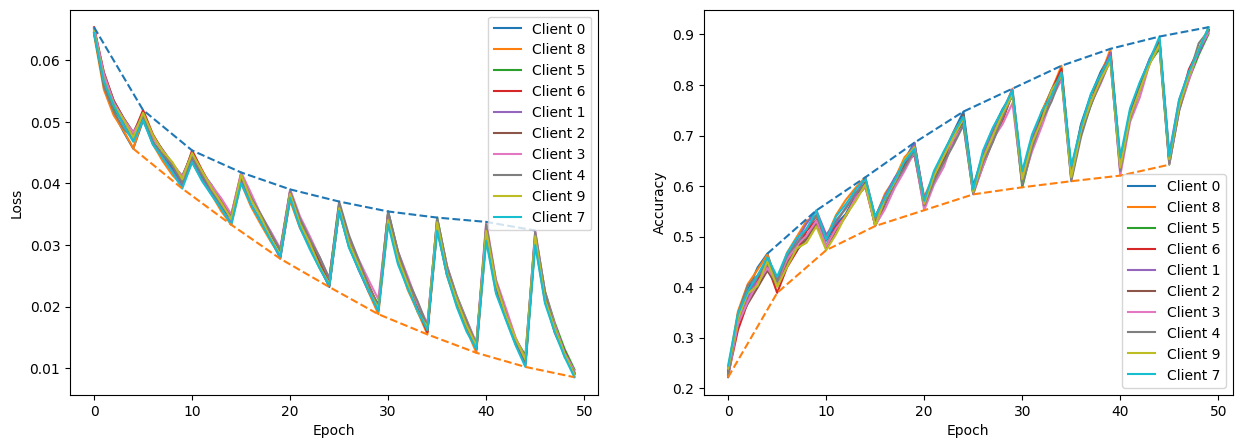

In [ ]:
plot_metrics(strategy_fed_avg.client_metrics)

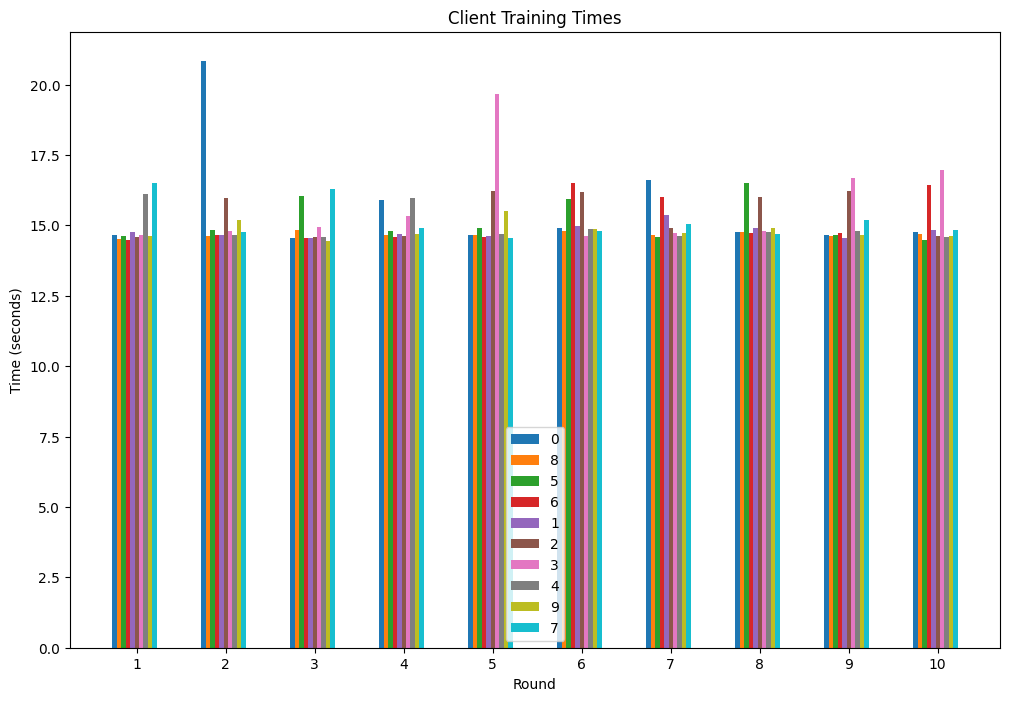

In [ ]:
plot_times(strategy_fed_avg.client_training_times)